# DSSATTools Perennial forage example notebook

In this notebook you'll see the basic usage of DSSATools library to:
1. Create the inputs
2. Initialize the simulation environment
3. Run simulations
4. Modify input objects
5. Create mowing schedule
5. Read outputs.

The idea of this library is to be a low-code interface to DSSAT

In [1]:
from DSSATTools import (
    Crop, SoilProfile, WeatherData, WeatherStation,
    Management, DSSAT
)
from DSSATTools.base.sections import TabularSubsection
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

## Create a WeatherData instance

In [2]:
# Random weather data
DATES = pd.date_range('2000-01-01', '2002-12-31')
N = len(DATES)
df = pd.DataFrame(
    {
    'tn': np.random.gamma(20, 1, N),
    'rad': np.random.gamma(15, 1.5, N),
    'prec': [0.0]* N,
    'rh': 100 * np.random.beta(1.5, 1.15, N),
    },
    index=DATES,
)
df['TMAX'] = df.tn + abs(np.random.normal(0, 8, N))
df.head()

,tn,rad,prec,rh,TMAX
2000-01-01,24.351623,22.882407,0.0,85.701940,32.807031
2000-01-02,25.492494,18.446851,0.0,54.157351,32.081925
2000-01-03,19.130440,34.550335,0.0,70.105508,24.525615
2000-01-04,22.578626,24.798779,0.0,85.105441,28.138721
2000-01-05,20.232143,20.360378,0.0,73.560307,35.967594


In [3]:
# Create a WeatherData instance
WTH_DATA = WeatherData(
    df,
    variables={
        'tn': 'TMIN', 'TMAX': 'TMAX',
        'prec': 'RAIN', 'rad': 'SRAD',
        'rh': 'RHUM'
    }
)
# Create a WheaterStation instance
wth = WeatherStation(
    WTH_DATA, 
    {'ELEV': 33, 'LAT': 0, 'LON': 0, 'INSI': 'dpoes'}
)

## Create a SoilProfile object from a default profile

In [4]:
# Soil instance from default soil profile
soil = SoilProfile(default_class='SIL')

## Create a Crop object from default crop file

In [5]:
# Crop
crop = Crop('alfalfa')
# Check how the cultivar looks like
crop.cultivar['AL0001']

{'VRNAME..........': 'Aragon  FD7',
 'EXPNO': '',
 'ECO#': 'G00001',
 'CSDL': 12.5,
 'PPSEN': 0.2,
 'EM-FL': 99.0,
 'FL-SH': 10.0,
 'FL-SD': 18.0,
 'SD-PM': 33.0,
 'FL-LF': 25.0,
 'LFMAX': 1.4,
 'SLAVR': 240.0,
 'SIZLF': 2.0,
 'XFRT': 0.01,
 'WTPSD': 0.02,
 'SFDUR': 15.0,
 'SDPDV': 2.05,
 'PODUR': 20.0,
 'THRSH': 78.0,
 'SDPRO': 0.115,
 'SDLIP': 0.035}

## Create a management instance

In [6]:
# Management instance
man = Management(
    cultivar='AL0001',
    planting_date=DATES[10],
    irrigation='A' # Automatic irrigation
)
# Modify mowing schedule
mow_schedule = pd.DataFrame({
    'DATE': [DATES[300].strftime('%y%j'), DATES[340].strftime('%y%j')], 
    'MOW': [1000, 1000], 'RSPLF': [20, 20], 'MVS': [2, 2], 'RSHT': [5, 5]
})
man.mow['table'] = TabularSubsection(mow_schedule)
# Check the simulation control value for Irrigation
man.simulation_controls['IRRIG']

'A'

## Setup the simulation environment and run the model

In [7]:
dssat = DSSAT()
dssat.setup()
dssat.run(
    soil=soil, weather=wth, crop=crop, management=man,
)

/tmp/fsyoodoz created.
Static files copied to /tmp/fsyoodoz.
RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 AL   1 -99 -99   -99  7097     0  3502  3562    15   -99   -99      0  141


Text(0, 0.5, 'Ton/ha')

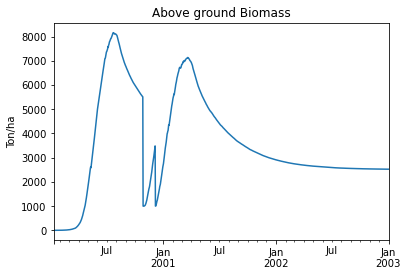

In [18]:
# Save the output
output_1 = dssat.output['PlantGro']
ax = output_1.CWAD.plot()
ax.set_title('Above ground Biomass')
ax.set_ylabel('Ton/ha')

Text(0, 0.5, 'Ton/ha')

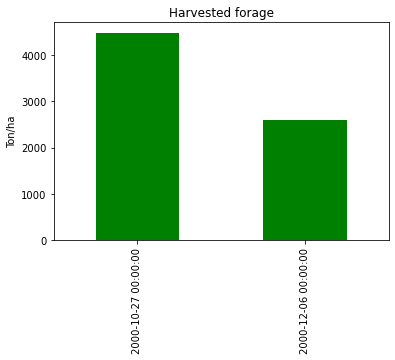

In [22]:
ax = output_1.loc[output_1.HERB > 0, 'HERB'].plot(kind='bar', color='g')
ax.set_title('Harvested forage')
ax.set_ylabel('Ton/ha')